Follow the official Tensorflow demo tutorial for Transformer based Translation: Transformer model for language understanding.

## Step1. Run the demo and train a model on the original Portuguese to English training set.

## Setup

In [242]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


Import the necessary modules:

In [243]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [244]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [245]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print('> Examples in Portuguese:')
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))
    print()

    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

In [246]:
# This tutorial uses the tokenizers built in https://www.tensorflow.org/text/guide/subwords_tokenizer.
# That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format.

# Note: This is different from https://arxiv.org/pdf/1706.03762.pdf, section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.

# Download, extract, and import the `saved_model`:

model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [247]:
tokenizers = tf.saved_model.load(model_name)

# The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:
tokenizer_items = [item for item in dir(tokenizers.en) if not item.startswith('_')]
print(', '.join(tokenizer_items))
print('\n')

# The `tokenize` method converts a batch of strings to a padded-batch of token IDs.
# This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing.
# That standardization is not visible here because the input data is already standardized.
print('> This is a batch of strings:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))
print('\n')

encoded = tokenizers.en.tokenize(en_examples)
print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)

# The `detokenize` method attempts to convert these token IDs back to human-readable text:
print('\n')
round_trip = tokenizers.en.detokenize(encoded)
print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

# The lower level `lookup` method converts from token-IDs to token text:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
print(tokens)

# The output demonstrates the "subword" aspect of the subword tokenization.

# For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`,
# and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

# Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

detokenize, get_reserved_tokens, get_vocab_path, get_vocab_size, lookup, tokenize, tokenizer, vocab


> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .
> This is the text split into tokens:
<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of'

...................................................

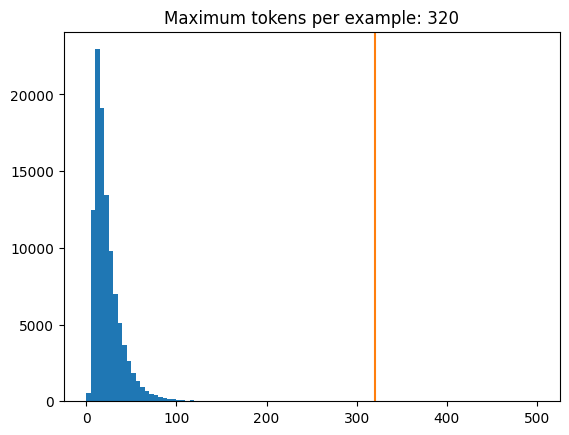

In [248]:
# The distribution of tokens per example in the dataset is as follows:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');
plt.show()

### Set up a data pipeline with `tf.data`

In [249]:
# The following function takes batches of text as input, and converts them to a format suitable for training.

# 1. It tokenizes them into ragged batches.
# 2. It trims each to be no longer than `MAX_TOKENS`.
# 3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
# 4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
# 5. It returns an `(inputs, labels)` pair.

MAX_TOKENS=128
def prepare_batch(pt, en, to_en=True):
    # to_en: determine if the translation is from Portuguese to English or vice versa
    if to_en:
        input = tokenizers.pt.tokenize(pt)      # Output is ragged.
    else:
        input = tokenizers.en.tokenize(en)
    input = input[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    input = input.to_tensor()  # Convert to 0-padded dense Tensor

    if to_en:
        target = tokenizers.en.tokenize(en)
    else:
        target = tokenizers.pt.tokenize(pt)
    target = target[:, :(MAX_TOKENS + 1)]
    target_inputs = target[:, :-1].to_tensor()  # Drop the [END] tokens
    target_labels = target[:, 1:].to_tensor()   # Drop the [START] tokens

    return (input, target_inputs), target_labels

In [250]:
# The function below converts a dataset of text examples into data of batches for training.

# 1. It tokenizes the text, and filters out the sequences that are too long.
#    (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
# 2. The `cache` method ensures that that work is only executed once.
# 3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples.
# 4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed.
#    See https://www.tensorflow.org/guide/data_performance.ipynb for details.

BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds, to_en=True):
    # to_en: determine if the translation is from Portuguese to English or vice versa
    return (
        ds
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(lambda p, e: prepare_batch(p, e, to_en), tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

## Test the Dataset

In [251]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [252]:
# It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
# It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until
# it gets the beginning right), but it can give a more stable model because the model has to learn to correct its own errors during training.
for (pt, en), en_labels in train_batches.take(1):
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)
print('\n')

# The en and en_labels are the same, just shifted by 1:
print(en[0][:10])
print(en_labels[0][:10])

(64, 100)
(64, 89)
(64, 89)


tf.Tensor([  2  45  91  50   9  56  89  37 205 430], shape=(10,), dtype=int64)
tf.Tensor([ 45  91  50   9  56  89  37 205 430  85], shape=(10,), dtype=int64)


In [253]:
# The embedding and positional encoding layer

# The original paper uses the following formula for calculating the positional encoding:

# $$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
# $$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

# Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated.
# Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)

    angle_rates = 1 / (10000 ** depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

# So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

# > Note: The original paper, section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages.
# This tutorial uses two separate tokenizers and weight matrices.

(2048, 512)


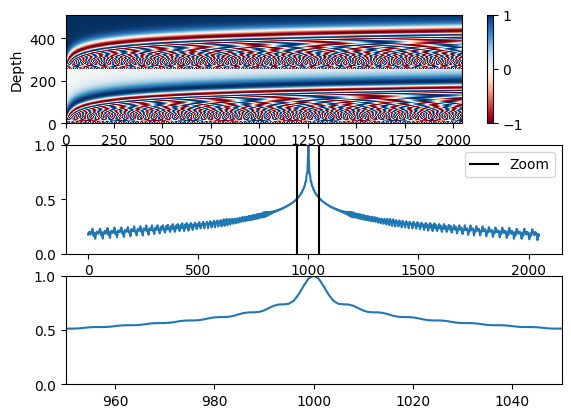

In [254]:
# The position encoding function is a stack of sines and cosines that vibrate at
# different frequencies depending on their location along the depth of the embedding vector.
# They vibrate across the position axis.

pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.subplot(3, 1, 1)
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()

# By definition these vectors align well with nearby vectors along the position axis.
# Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd, d -> p', pos_encoding, p)
plt.subplot(3, 1, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0, 1, float('nan'), 0, 1], color='k', label='Zoom')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0, 1])
plt.show()

In [255]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

en_emb._keras_mask

<tf.Tensor: shape=(64, 89), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [256]:
# These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.
# The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.
# The residual "Add & Norm" blocks are included so that training is efficient.
# The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**),
#   while the normalization maintains a reasonable scale for the outputs.
# Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).

# The base attention layer
## Attention layers are used throughout the model. These are all identical except for how the attention is configured.
## Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

# The cross attention layer
## At the literal center of the Transformer is the cross-attention layer.
## This layer connects the encoder and decoder.
## This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in https://www.tensorflow.org/text/tutorials/nmt_with_attention.
## To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer.
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
                        query=x,
                        key=context,
                        value=context,
                        return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x


# The global self attention layer
## This layer is responsible for processing the context sequence, and propagating information along its length.
## lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

# The causal self attention layer
## This layer does a similar job as the global self attention layer, for the output sequence.
## This needs to be handled differently from the encoder's global self attention layer.
## Like the text generation tutorial, and the NMT with attention tutorial, Transformers are an "autoregressive" model:
##   They generate the text one token at a time and feed that output back to the input.
## To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".
## A causal model is efficient in two ways:
### In training, it lets you compute loss for every location in the output sequence while executing the model just once.
### During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
## To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.
## This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

# The causal mask ensures that each location only has access to the locations that come before it.

In [257]:
# The feed forward network
## Point-wise feed-forward network in both the encoder and decoder
## The network consists of two linear layers (tf.keras.layers.Dense) with a ReLU activation in-between, and a dropout layer.
## As with the attention layers the code here also includes the residual connection and normalization

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
            ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x


In [258]:
# The encoder layer
## The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

# The encoder
## A PositionalEmbedding layer at the input.
## A stack of EncoderLayer layers.

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [259]:
# The decoder layer
## The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 d_model,
                 num_heads,
                 dff,
                 dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

# The decoder
## Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s.
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
          x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [260]:
# # To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

print('Cross Attention test')
sample_ca = CrossAttention(num_heads=2, key_dim=512)
print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)


print('\n--------------------------\n')
print('Global Self Attention test')
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)


print('\n--------------------------\n')
print('Causal Self Attention test')
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
print(en_emb.shape)
print(sample_csa(en_emb).shape)


print('\n--------------------------\n')
# The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:
print('Trim elements test')
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]
print(out1.shape)
print(out2.shape)
print(tf.reduce_max(abs(out1 - out2)).numpy())
# Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions.


print('\n--------------------------\n')
print('Feed Forward test')
sample_ffn = FeedForward(512, 2048)
print(en_emb.shape)
print(sample_ffn(en_emb).shape)


print('\n--------------------------\n')
print('Encoder layer test')
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)


print('\n--------------------------\n')
print('Encoder test')
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)
sample_encoder_output = sample_encoder(pt, training=False)
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.


print('\n--------------------------\n')
print('Decoder layer test')
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=en_emb, context=pt_emb)
print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`


print('\n--------------------------\n')
print('Decoder test')
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)
output = sample_decoder(x=en, context=pt_emb)
print(en.shape)
print(pt_emb.shape)
print(output.shape)

sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

Cross Attention test
(64, 100, 512)
(64, 89, 512)
(64, 89, 512)

--------------------------

Global Self Attention test
(64, 100, 512)
(64, 100, 512)

--------------------------

Causal Self Attention test
(64, 89, 512)
(64, 89, 512)

--------------------------

Trim elements test
(64, 3, 512)
(64, 3, 512)
4.7683716e-07

--------------------------

Feed Forward test
(64, 89, 512)
(64, 89, 512)

--------------------------

Encoder layer test
(64, 100, 512)
(64, 100, 512)

--------------------------

Encoder test
(64, 100)
(64, 100, 512)

--------------------------

Decoder layer test
(64, 89, 512)
(64, 100, 512)
(64, 89, 512)

--------------------------

Decoder test
(64, 89)
(64, 100, 512)
(64, 89, 512)


TensorShape([64, 8, 89, 100])

In [261]:
# The Transformer
## You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer
##   which converts the resulting vector at each location into output token probabilities.
## The output of the decoder is the input to this final linear layer.

## A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from https://www.tensorflow.org/text/tutorials/nmt_with_attention.
## A multi-layer Transformer has more layers, but is fundamentally doing the same thing.\

## Create the `Transformer` by extending `tf.keras.Model`:
## Note: The original paper, section 3.4, shares the weight matrix between the embedding layer and the final linear layer.
##   To keep things simple, this tutorial uses two separate weight matrices.

class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [262]:
# Hyperparameters
# To keep this example small and relatively fast, the number of layers (`num_layers`),
# the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.
# The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.
# The number of self-attention heads remains the same (`num_heads=8`).

num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [263]:
# Test
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 89)
(64, 100)
(64, 89, 7010)
(64, 8, 89, 100)


In [264]:
transformer.summary()

Model: "transformer_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_15 (Encoder)        multiple                  3632768   
                                                                 
 decoder_15 (Decoder)        multiple                  5647104   
                                                                 
 dense_306 (Dense)           multiple                  904290    
                                                                 
Total params: 10184162 (38.85 MB)
Trainable params: 10184162 (38.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [265]:
# Optimizer
## Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).
## $$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
      super().__init__()

      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)

      self.warmup_steps = warmup_steps

    def __call__(self, step):
      step = tf.cast(step, dtype=tf.float32)
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)

      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
# Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [266]:
# Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.
# Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

# Loss
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss

# metric: accuracy
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [267]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [268]:
# Train the model
epochs=15

transformer.fit(train_batches,
                epochs=epochs,
                validation_data=val_batches)

Epoch 1/15
810/810 [==============================] - 233s 254ms/step - loss: 6.5970 - masked_accuracy: 0.1461 - val_loss: 5.0371 - val_masked_accuracy: 0.2484
Epoch 2/15
810/810 [==============================] - 195s 240ms/step - loss: 4.5625 - masked_accuracy: 0.3000 - val_loss: 4.1230 - val_masked_accuracy: 0.3426
Epoch 3/15
810/810 [==============================] - 192s 237ms/step - loss: 3.8188 - masked_accuracy: 0.3811 - val_loss: 3.4310 - val_masked_accuracy: 0.4336
Epoch 4/15
810/810 [==============================] - 193s 239ms/step - loss: 3.2778 - masked_accuracy: 0.4398 - val_loss: 3.0001 - val_masked_accuracy: 0.4851
Epoch 5/15
810/810 [==============================] - 193s 238ms/step - loss: 2.8837 - masked_accuracy: 0.4847 - val_loss: 2.7353 - val_masked_accuracy: 0.5230
Epoch 6/15
810/810 [==============================] - 192s 236ms/step - loss: 2.5686 - masked_accuracy: 0.5230 - val_loss: 2.5099 - val_masked_accuracy: 0.5482
Epoch 7/15
810/810 [====================

In [269]:
# Run inference

## You can now test the model by performing a translation. The following steps are used for inference:
## * Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
## * The decoder input is initialized to the `[START]` token.
## * Calculate the padding masks and the look ahead masks.
## * The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
## * Concatenate the predicted token to the decoder input and pass it to the decoder.
## * In this approach, the decoder predicts the next token based on the previous tokens it predicted.
## Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously.
##   This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).
## Define the `Translator` class by subclassing `tf.Module`

# Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call.
# Refer to nmt_with_attention.ipynb tutorial for an example implementation with a dynamic loop, which can be much more efficient.

class Translator(tf.Module):
    def __init__(self, tokenizers, transformer, to_en=True):
        # to_en: determine if the translation is from Portuguese to English or vice versa
        self.tokenizers = tokenizers
        self.transformer = transformer
        self.to_en = to_en

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        if self.to_en:
            sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
        else:
            sentence = self.tokenizers.en.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        if self.to_en:
            start_end = self.tokenizers.en.tokenize([''])[0]
        else:
            start_end = self.tokenizers.pt.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i + 1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        if self.to_en:
            text = self.tokenizers.en.detokenize(output)[0]  # Shape: `()`.
            tokens = self.tokenizers.en.lookup(output)[0]
        else:
            text = self.tokenizers.pt.detokenize(output)[0]  # Shape: `()`.
            tokens = self.tokenizers.pt.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:, :-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [270]:
# Create an instance of this `Translator` class, and try it out a few times:
translator = Translator(tokenizers, transformer)

# Example 1
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
print('\n')

# Example 2
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
print('\n')

# Example 3
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
print('\n')

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share a lot of quickly sharing some stories that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.




In [271]:
# Create attention plots
# The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

# Create a function that plots the attention when a token is generated:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)
    plt.show()

sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [272]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
print(attention.shape)
print('\n')

# These are the input (Portuguese) tokens
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
print(in_tokens)
print('\n')

# And these are the output (English translation) tokens
print(translated_tokens)

# plot_attention_head(in_tokens, translated_tokens, attention)

(9, 11)


tf.Tensor(
[b'[START]' b'este' b'e' b'o' b'primeiro' b'livro' b'que' b'eu' b'fiz'
 b'.' b'[END]'], shape=(11,), dtype=string)


tf.Tensor(
[b'[START]' b'this' b'is' b'the' b'first' b'book' b'i' b'did' b'.'
 b'[END]'], shape=(10,), dtype=string)


In [285]:
def plot_attention_weights(sentence, translated_tokens, attention_heads, to_en=True):
    # to_en: determine if the translation is from Portuguese to English or vice versa
    in_tokens = tf.convert_to_tensor([sentence])
    if to_en:
        in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
        in_tokens = tokenizers.pt.lookup(in_tokens)[0]
    else:
        in_tokens = tokenizers.en.tokenize(in_tokens).to_tensor()
        in_tokens = tokenizers.en.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

# plot_attention_weights(sentence, translated_tokens, attention_weights[0])

In [274]:
# The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset,
#   and the model attempts to transliterate them even without a shared vocabulary. For example

sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

# plot_attention_weights(sentence, translated_tokens, attention_weights[0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triccoophos in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


## Step2. Train a New model of the same architecture on the opposite training set (English to Portuguese)

In [275]:
# Create training and validation set batches for English to Portuguese
train_batches_2 = make_batches(train_examples, to_en=False)
val_batches_2 = make_batches(val_examples, to_en=False)

In [276]:
transformer_2 = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [277]:
learning_rate = CustomSchedule(d_model)
# Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [278]:
transformer_2.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [279]:
transformer_2.fit(train_batches_2,
                  epochs=epochs,
                  validation_data=val_batches_2)

Epoch 1/15
810/810 [==============================] - 234s 256ms/step - loss: 6.8500 - masked_accuracy: 0.1242 - val_loss: 5.3278 - val_masked_accuracy: 0.2211
Epoch 2/15
810/810 [==============================] - 196s 242ms/step - loss: 4.8638 - masked_accuracy: 0.2568 - val_loss: 4.2291 - val_masked_accuracy: 0.3157
Epoch 3/15
810/810 [==============================] - 196s 242ms/step - loss: 4.0281 - masked_accuracy: 0.3325 - val_loss: 3.6305 - val_masked_accuracy: 0.3787
Epoch 4/15
810/810 [==============================] - 195s 240ms/step - loss: 3.4281 - masked_accuracy: 0.3989 - val_loss: 3.1427 - val_masked_accuracy: 0.4421
Epoch 5/15
810/810 [==============================] - 195s 241ms/step - loss: 2.9902 - masked_accuracy: 0.4491 - val_loss: 2.8215 - val_masked_accuracy: 0.4838
Epoch 6/15
810/810 [==============================] - 194s 240ms/step - loss: 2.6510 - masked_accuracy: 0.4924 - val_loss: 2.5387 - val_masked_accuracy: 0.5215
Epoch 7/15
810/810 [====================

In [280]:
# Create an instance of this `Translator` class, and try it out a few times:
translator_2 = Translator(tokenizers, transformer_2, to_en=False)

# Example 1
sentence = 'this is a problem we have to solve .'
ground_truth = 'este é um problema que temos que resolver.'
translated_text, translated_tokens, attention_weights = translator_2(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
print('\n')

# Example 2
sentence = 'and my neighboring homes heard about this idea .'
ground_truth = 'os meus vizinhos ouviram sobre esta ideia.'
translated_text, translated_tokens, attention_weights = translator_2(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
print('\n')

# Example 3
sentence = "so i'll just share with you some stories very quickly of some magical things that have happened."
ground_truth = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
translated_text, translated_tokens, attention_weights = translator_2(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
print('\n')

Input:         : this is a problem we have to solve .
Prediction     : este e um problema que temos de resolver .
Ground truth   : este é um problema que temos que resolver.


Input:         : and my neighboring homes heard about this idea .
Prediction     : e as minhas casas de vizinho acabaram de falar sobre esta ideia .
Ground truth   : os meus vizinhos ouviram sobre esta ideia.


Input:         : so i'll just share with you some stories very quickly of some magical things that have happened.
Prediction     : vou partilhar convosco algumas historias muito rapidamente de algumas coisas magicos que aconteceram .
Ground truth   : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.




## Step3. Insert novel sentences into your English to Portuguese model. Take the output and feed it to the original Portuguese to English model. Observe and report qualitatively on the results

In [281]:
def en_2_pt_2_en(ground_truth, pt_trans, en_trans):
    print(f'{"Ground truth:":15s}\t\t: {ground_truth}')
    print(f'{"Translated Portuguese":15s}\t: {pt_trans}')
    print(f'{"Translated English":15s}\t: {en_trans}')

In [282]:
print('Example 1')  # George Orwell, "1984"
sentence_1 = 'It was a bright cold day in April, and the clocks were striking thirteen as Winston Smith gazed out of the small apartment window'
tra_pt_1, tra_tk_pt_1, att_w_pt_1 = translator_2(tf.constant(sentence_1))
tra_pt_1 = tra_pt_1.numpy().decode("utf-8")
tra_en_1, tra_tk_en_1, att_w_en_1 = translator(tf.constant(tra_pt_1))
en_2_pt_2_en(sentence_1, tra_pt_1, tra_en_1)
print('\n')

print('Example 2')  # Dr. Seuss, "The Cat in the Hat"
sentence_2 = 'The sun did not shine, it was too wet to play, so we sat in the house all that cold, cold, wet day.'
tra_pt_2, tra_tk_pt_2, att_w_pt_2 = translator_2(tf.constant(sentence_2))
tra_pt_2 = tra_pt_2.numpy().decode("utf-8")
tra_en_2, tra_tk_en_2, att_w_en_2 = translator(tf.constant(tra_pt_2))
en_2_pt_2_en(sentence_2, tra_pt_2, tra_en_2)
print('\n')

print('Example 3')  # Leo Tolstoy, "Anna Karenina"
sentence_3 = "Happy families are all alike; every unhappy family is unhappy in its own way."
tra_pt_3, tra_tk_pt_3, att_w_pt_3 = translator_2(tf.constant(sentence_3))
tra_pt_3 = tra_pt_3.numpy().decode("utf-8")
tra_en_3, tra_tk_en_3, att_w_en_3 = translator(tf.constant(tra_pt_3))
en_2_pt_2_en(sentence_3, tra_pt_3, tra_en_3)
print('\n')

print('Example 4')  # F. Scott Fitzgerald, "The Great Gatsby"
sentence_4 = "In my younger and more vulnerable years, my father gave me some advice that I've been turning over in my mind ever since."
tra_pt_4, tra_tk_pt_4, att_w_pt_4 = translator_2(tf.constant(sentence_4))
tra_pt_4 = tra_pt_4.numpy().decode("utf-8")
tra_en_4, tra_tk_en_4, att_w_en_4 = translator(tf.constant(tra_pt_4))
en_2_pt_2_en(sentence_4, tra_pt_4, tra_en_4)
print('\n')

print('Example 5')  # Alanis Morissette, "Jagged Little Pill"
sentence_5 = "The moment I let go of it was the moment I got more than I could handle. The moment I jumped off of it was the moment I touched down."
tra_pt_5, tra_tk_pt_5, att_w_pt_5 = translator_2(tf.constant(sentence_5))
tra_pt_5 = tra_pt_5.numpy().decode("utf-8")
tra_en_5, tra_tk_en_5, att_w_en_5 = translator(tf.constant(tra_pt_5))
en_2_pt_2_en(sentence_5, tra_pt_5, tra_en_5)
print('\n')

Example 1
Ground truth:  		: It was a bright cold day in April, and the clocks were striking thirteen as Winston Smith gazed out of the small apartment window
Translated Portuguese	: foi um dia mais frio em abril e as relogios foram chocantes como se estremelhaveis se espalhou a olhar para fora da janela pequena apartamento em apartamento .
Translated English	: b"it was a colder in april , and the clocks were shocking , like you ' re crushed if you ' re looking at it outside the small apartment in apartment apartment ."


Example 2
Ground truth:  		: The sun did not shine, it was too wet to play, so we sat in the house all that cold, cold, wet day.
Translated Portuguese	: o sol nao incidire , tambem era suposto tocar , por isso estivemos em casa toda aquela fria , fria e frio dia .
Translated English	: b"the sun was n ' t supposed to play , so we ' ve been playing it , so we ' ve been sitting in all that cold , cold , cold and cold day ."


Example 3
Ground truth:  		: Happy families a

The translation from English to Portuguese seems to perform not as well as from Portuguese to English. Transaltor_2, which is the translator from English to Portuguese, is able to translate words but has a problem combining words into meaningful sentences. For instance, 'estremelhaveis' in Portuguese means striking, trembling and shocking. However, translator_2 somehow missed "thirteen" in the process, thus the translator picked shocking to try to match the context. Also, when translator_2 sees words thata are not in training during inference, it attempted to transliterate like the Portuguese to English translator, but the meaning of the original word is lost in the translation. Therefore, when tranlating back to English, the sentence became unrecognizable. In conclusion, to improve this process, both translators should be trained with more epochs, more data, and the hyperparameters should be selected to the values close to the original paper.

Below we can see that the attention weights' heatmap during the inference of the first sentence from Portuguese to English. As we can wee, that part is all over the place, meaning that the model struggles to pick a word, as a bunch of them have similar attentions. Under that was the attention weights' heatmap during the inference from English to Portuguese. We can see that distribution in those heatmaps are more focused, meaning that the Portuguese to English translator is able to capture the meaning of the first sentence. However, as we saw it above, because the meaning was lost in the first translation, the outcome from the second translator did not match the ground truth.

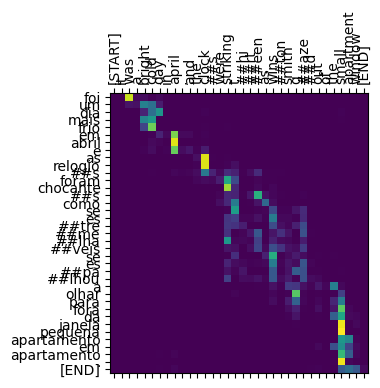

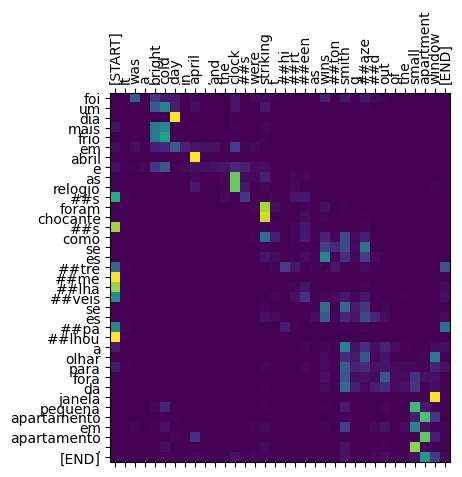

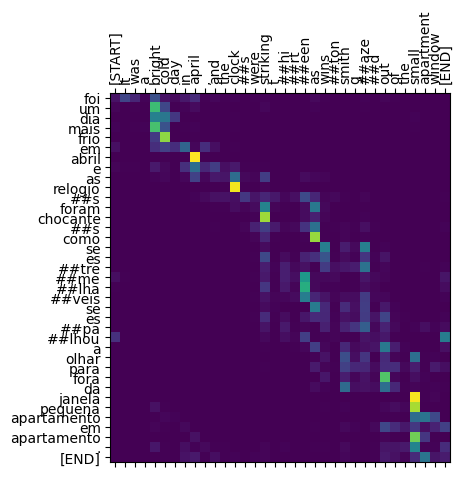

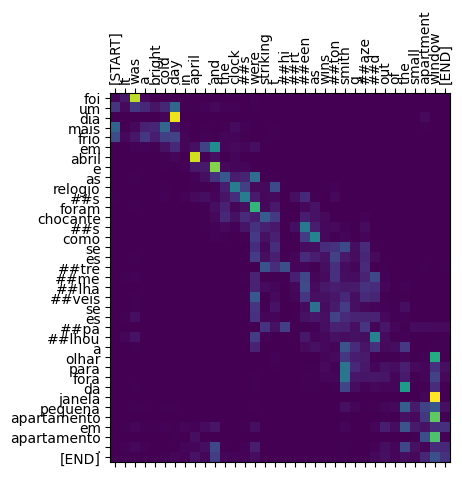

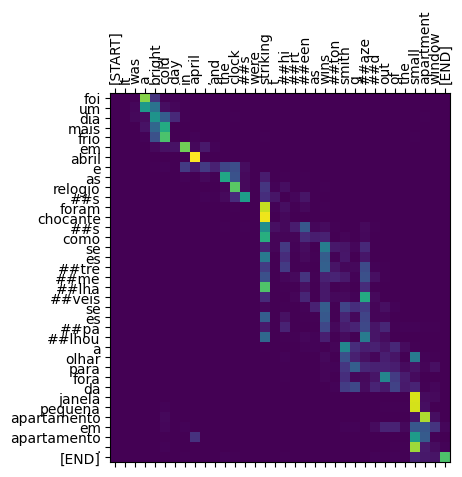

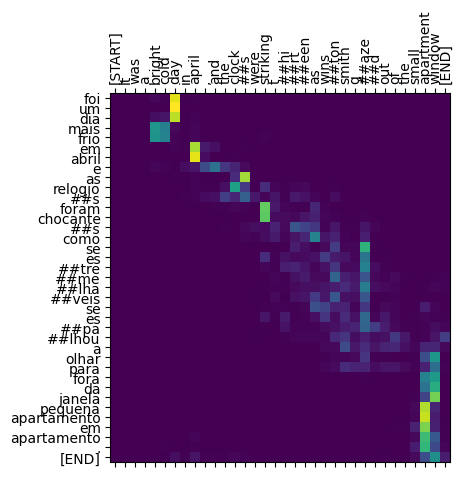

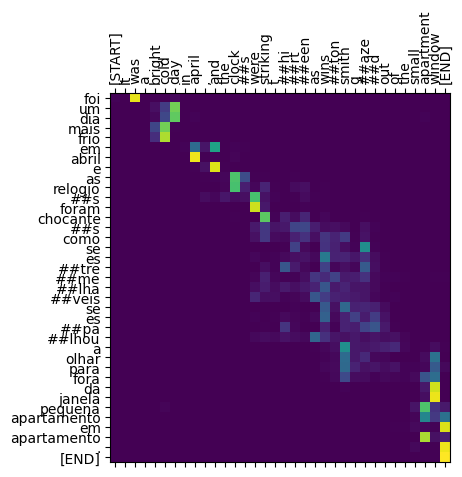

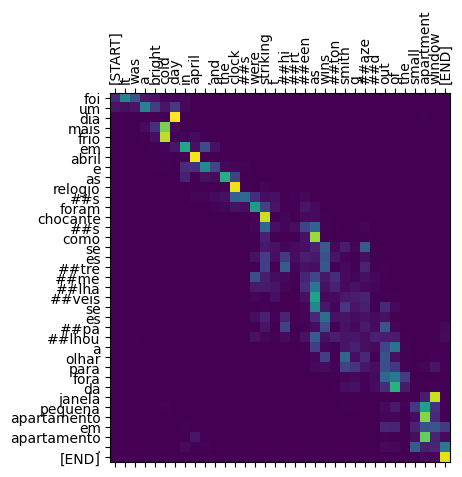

<Figure size 640x480 with 0 Axes>

In [287]:
plot_attention_weights(sentence_1, tra_tk_pt_1, att_w_pt_1[0], False)

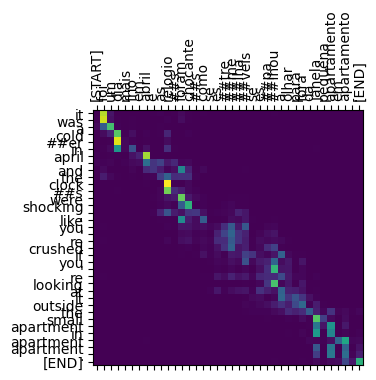

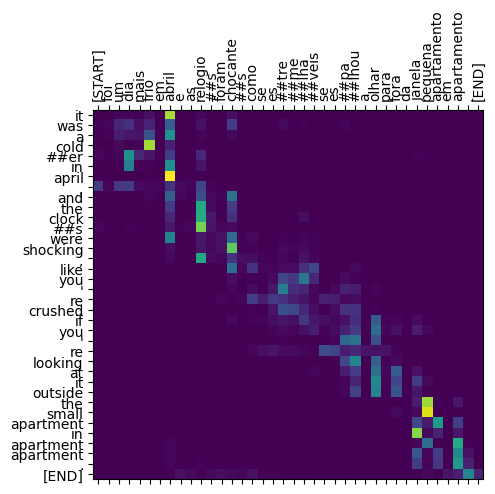

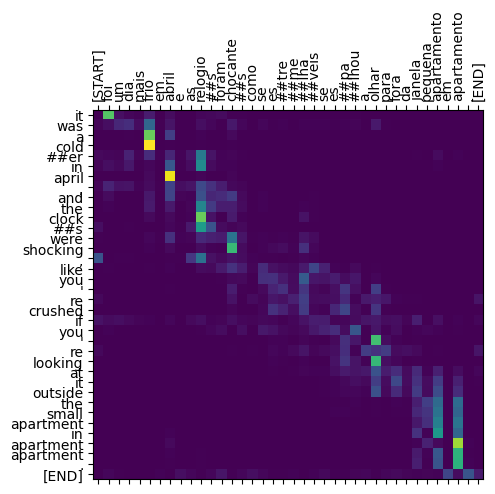

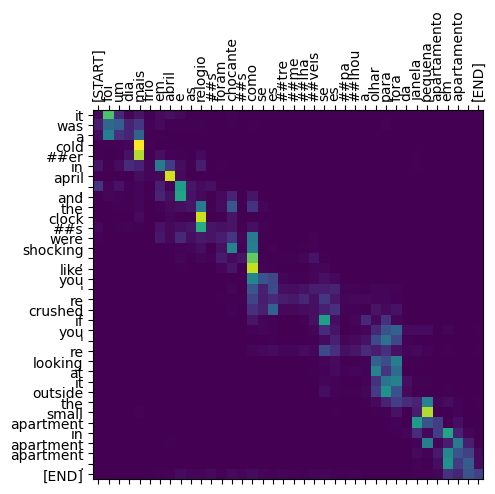

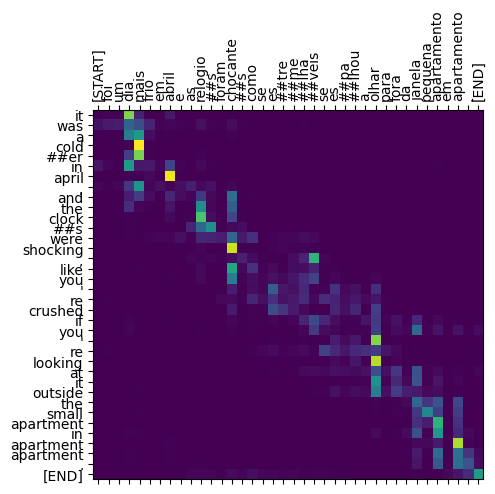

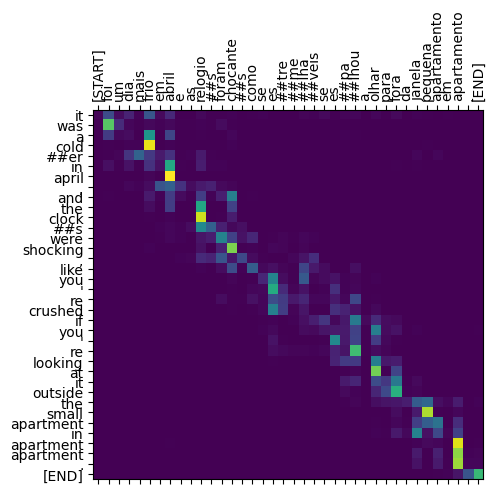

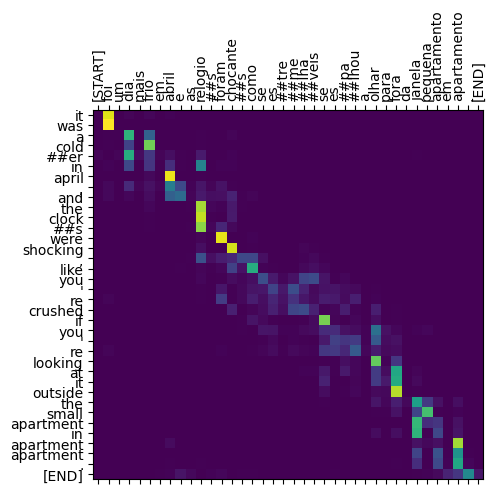

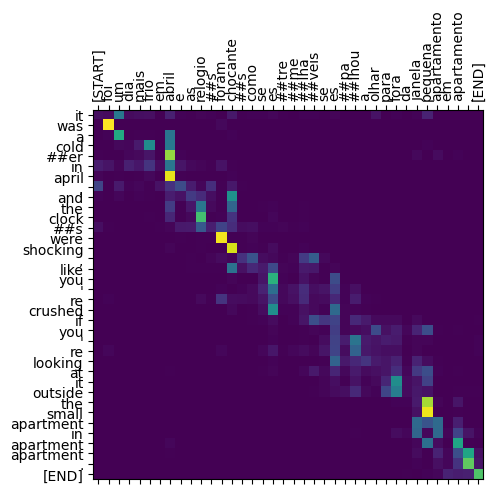

<Figure size 640x480 with 0 Axes>

In [284]:
plot_attention_weights(tra_pt_1, tra_tk_en_1, att_w_en_1[0])